In [239]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Brayan Acevedo
### Eugenio Pacceli
### Renato Oliveira

## Standard Errors of Estimated Stereo Camera Parameters with toolbox of MatLab
			-----------------------------------------------------

Camera 1 Intrinsics
-------------------
Focal length (pixels):   [ 1536.2219 +/- 27.9990    1564.3348 +/- 31.1414 ]

Principal point (pixels):[  486.9623 +/- 19.5389     366.6089 +/- 2.5640  ]

Radial distortion:       [    0.0275 +/- 0.0109       -0.0078 +/- 0.0346  ]


Camera 1 Extrinsics
-------------------
Rotation vectors:

                         [   -0.1716 +/- 0.0035        0.4051 +/- 0.0095        0.0152 +/- 0.0014  ]
                         
                         [    0.0987 +/- 0.0030        0.4120 +/- 0.0096       -0.0283 +/- 0.0005  ]
                         
                         [   -0.1067 +/- 0.0050        0.1931 +/- 0.0060       -1.5981 +/- 0.0006  ]


Translation vectors (mm):

                         [ -203.9184 +/- 16.5292     127.5897 +/- 2.2224     1319.2953 +/- 25.0793 ]
                         
                         [  185.9769 +/- 12.4631    -119.1853 +/- 1.5444      951.5604 +/- 19.0048 ]
                         
                         [  258.6195 +/- 12.2334       2.9324 +/- 1.5082      929.6966 +/- 18.4015 ]



Camera 2 Intrinsics
-------------------
Focal length (pixels):   [ 1538.2545 +/- 23.8018    1575.0879 +/- 28.4591 ]

Principal point (pixels):[  480.3704 +/- 20.8470     420.4541 +/- 1.9757  ]

Radial distortion:       [    0.0675 +/- 0.0106       -0.1337 +/- 0.0306  ]


Position And Orientation of Camera 2 Relative to Camera 1
---------------------------------------------------------
Rotation of camera 2:         [    0.9955 +/- 0.0014       -0.0543 +/- 0.0040        0.0772 +/- 0.0003  ]

Translation of camera 2 (mm): [  -62.7594 +/- 1.6088        0.5922 +/- 0.5710       15.7207 +/- 7.3693  ]

## The calibration results on the calibration images using the matlab toolbox were as follows

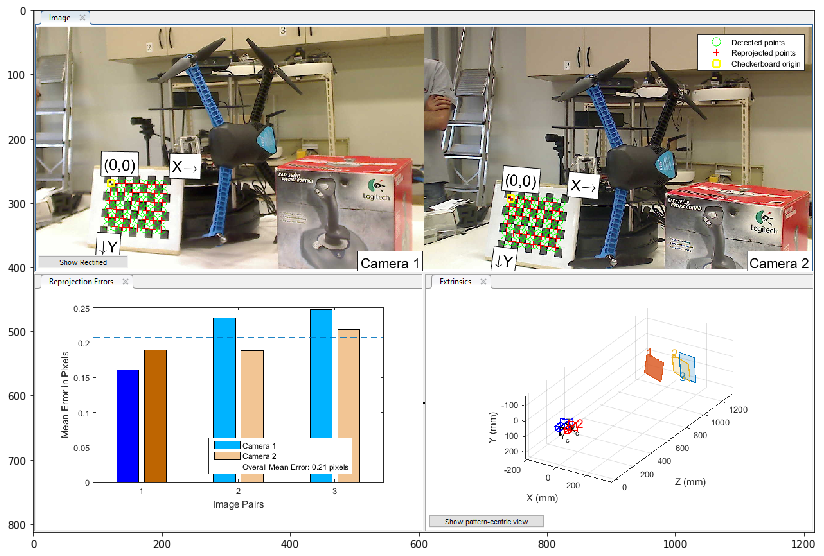

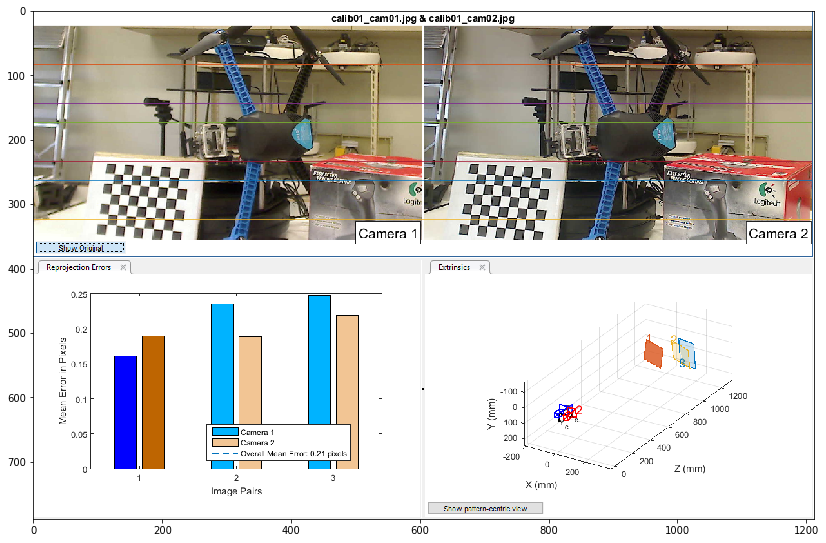

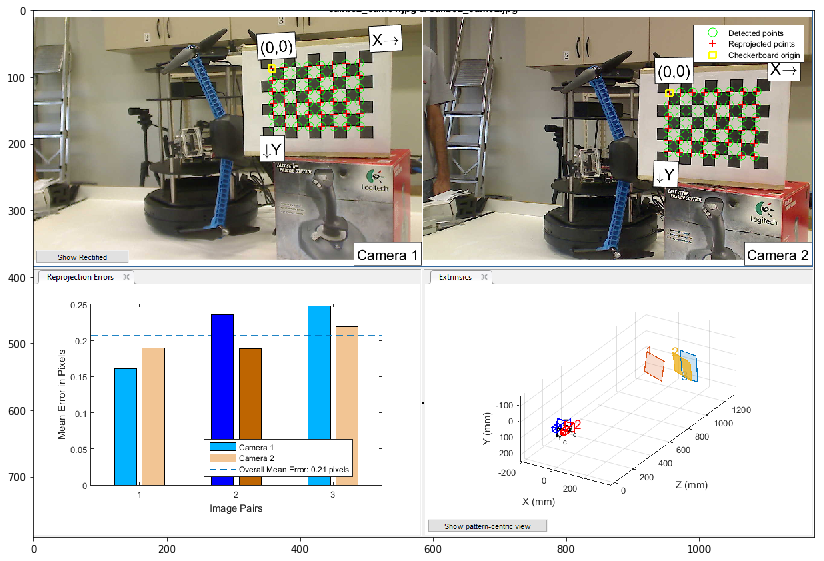

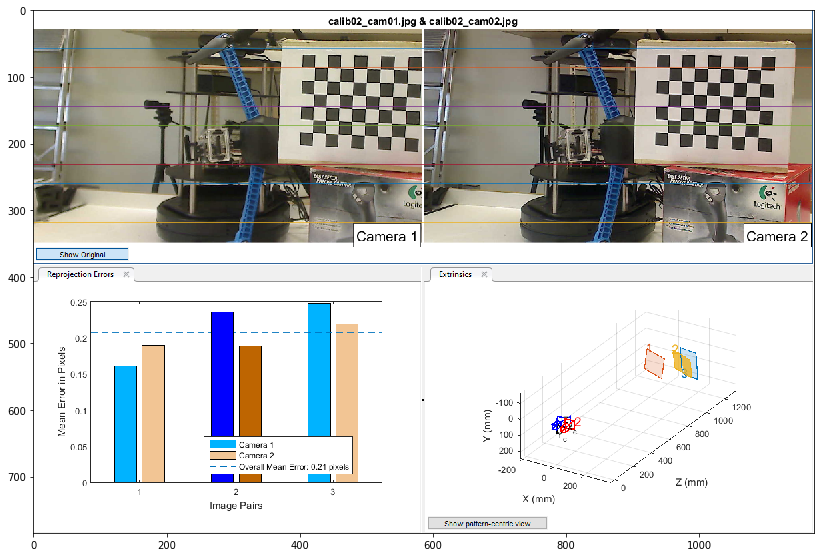

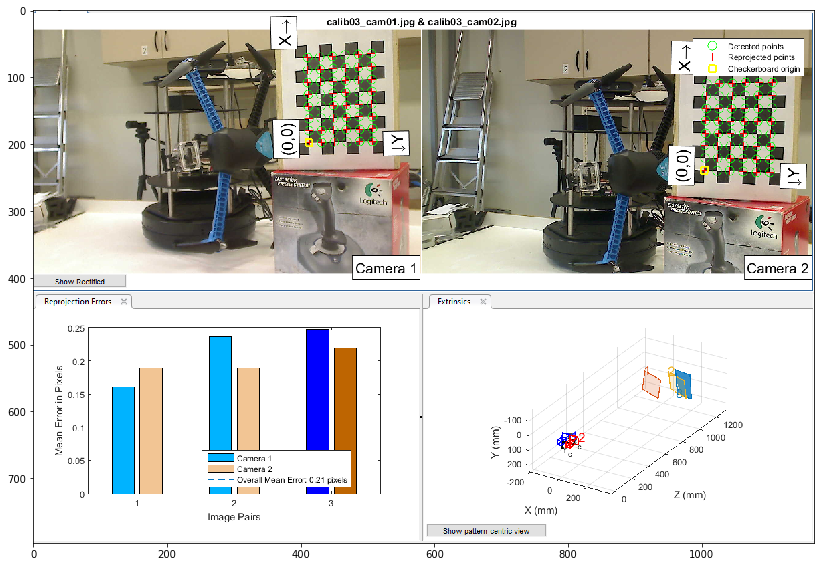

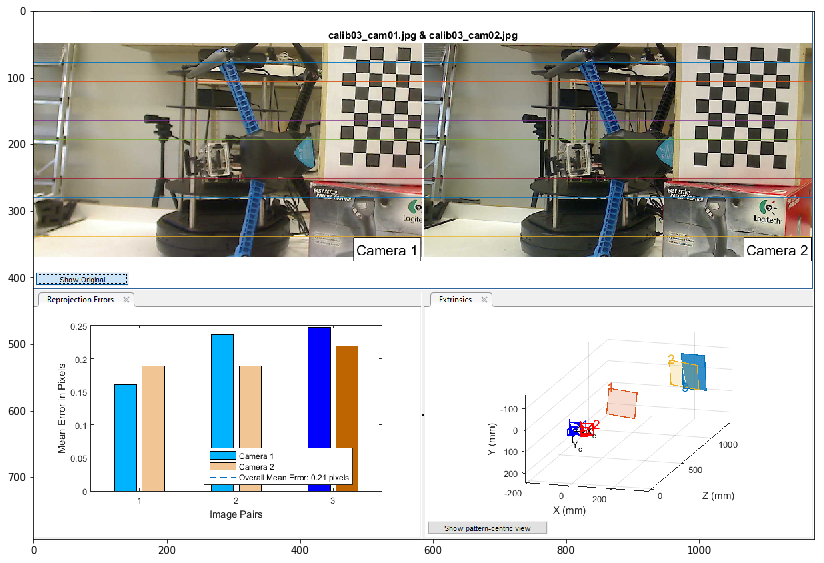

In [240]:
par01_1 = cv2.imread ('fotosparstereo/par01_1.png', cv2.IMREAD_COLOR)
par01_1 = cv2.cvtColor(par01_1, cv2.COLOR_BGR2RGB)
par01_2 = cv2.imread ('fotosparstereo/par01_2.png', cv2.IMREAD_COLOR)
par01_2 = cv2.cvtColor(par01_2, cv2.COLOR_BGR2RGB)

par02_1 = cv2.imread ('fotosparstereo/par02_1.png', cv2.IMREAD_COLOR)
par02_1 = cv2.cvtColor(par02_1, cv2.COLOR_BGR2RGB)
par02_2 = cv2.imread ('fotosparstereo/par02_2.png', cv2.IMREAD_COLOR)
par02_2 = cv2.cvtColor(par02_2, cv2.COLOR_BGR2RGB)

par03_1 = cv2.imread ('fotosparstereo/par03_1.png', cv2.IMREAD_COLOR)
par03_1 = cv2.cvtColor(par03_1, cv2.COLOR_BGR2RGB)
par03_2 = cv2.imread ('fotosparstereo/par03_2.png', cv2.IMREAD_COLOR)
par03_2 = cv2.cvtColor(par03_2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14,14))
plt.imshow(par01_1)
plt.show()
plt.figure(figsize=(14,14))
plt.imshow(par01_2)
plt.show()
plt.figure(figsize=(14,14))
plt.imshow(par02_1)
plt.show()
plt.figure(figsize=(14,14))
plt.imshow(par02_2)
plt.show()
plt.figure(figsize=(14,14))
plt.imshow(par03_1)
plt.show()
plt.figure(figsize=(14,14))
plt.imshow(par03_2)
plt.show()



* We initially calculate all the matches between the two images, for this we use the algorithm SIFT for detection and calculation of characteristic points and FLANN based matcher and ratio test, and RANSAC to filter the outliers.

* Once obtained the matches of characteristic points between the images, let's find the Fundamental Matrix. For this we use the opencv function "cv2.findFundamentalMat".

* Next step is find the epilines, the epilines corresponding to the points in first image is drawn on second image.

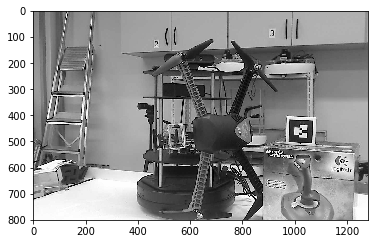

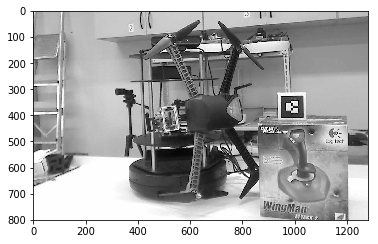


Fundamental matrix is
[[  2.10112896e-07  -2.81777447e-06   2.06809487e-03]
 [  3.89351427e-06   3.79762936e-07   1.66367778e-02]
 [ -1.45507011e-03  -1.76460948e-02   1.00000000e+00]]

Fundamental matrix error check: -0.006291
 


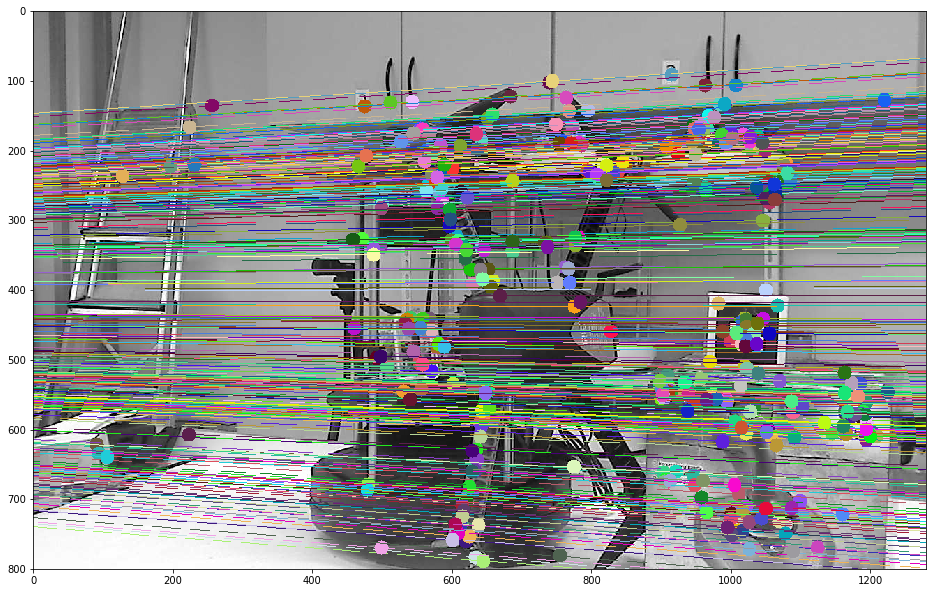

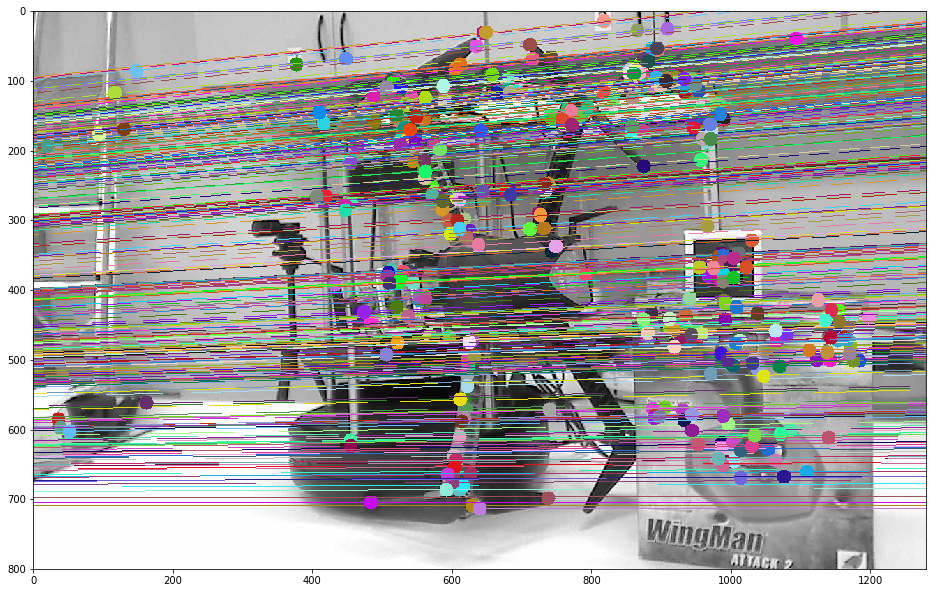

In [241]:
img1 = cv2.imread('fotosparstereo/scene_cam02.jpg',0)  # left image
img2 = cv2.imread('fotosparstereo/scene_cam01.jpg',0)  # right image
plt.imshow(img1,cmap = 'gray')
plt.show()
plt.imshow(img2,cmap = 'gray')
plt.show()

# find the keypoints and descriptors with SIFT
sift = cv2.xfeatures2d.SIFT_create()
kpA, desA = sift.detectAndCompute(img1,None)
kpB, desB = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desA,desB,k=2)

good = []
pts1 = []
pts2 = []

# ratio test 
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kpB[m.trainIdx].pt)
        pts1.append(kpA[m.queryIdx].pt)
        
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

#find the Fundamental Matrix usin RANSAC.
F, mask = cv2.findFundamentalMat(pts1,pts2, cv2.FM_RANSAC)
matchesMask = mask.ravel().tolist() 
# select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)
print ()
print ("Fundamental matrix is")
print (F)

pt1 = np.array([[pts1[0][0]], [pts1[0][1]], [1]])
pt2 = np.array([[pts2[0][0], pts2[0][1], 1]])
print ()
print ("Fundamental matrix error check: %f"%np.dot(np.dot(pt2,F),pt1))
print (" ")



def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img1
        lines - corresponding epilines '''
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv2.line(img1, (x0,y0), (x1,y1), color,1)
        cv2.circle(img1,tuple(pt1), 10, color, -1)
        cv2.circle(img2,tuple(pt2), 10,color,-1)
    return img1,img2

# drawing lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
plt.figure(figsize=(16,16))
plt.imshow(img5,cmap = 'gray')
plt.show()

# drawing lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(16,16))
plt.imshow(img3,cmap = 'gray')
plt.show()



We also have the matrix K which contains the intrinsic parameters of the camera, the matrix of rotation R and translation T.

With this information we make the rectification of the images as shown below.


matrix K for img1 is
[[  1.53622190e+03   0.00000000e+00   4.80370400e+02]
 [  0.00000000e+00   1.57508790e+03   4.20454100e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

matrix K for img2 is
[[  1.53825450e+03   0.00000000e+00   4.80370400e+02]
 [  0.00000000e+00   1.57508790e+03   4.20454100e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

The essential matrix E for img1 is
[[  0.49586176  -6.81812528   1.51207566]
 [  9.42107623   0.94215459  29.40181889]
 [  0.4346063  -29.67465191   1.20299852]]


The essential matrix E for img2 is
[[  0.49717479  -6.82714645   1.51407631]
 [  9.43354141   0.94215459  29.40181889]
 [  0.43518134 -29.67465191   1.20299852]]


Pitch: -1.524775, Yaw: 4.842523, Roll: 2.913615

Rotation matrix:
[[ 0.9951424   0.05064883 -0.08441738]
 [-0.05305565  0.9982395  -0.02651422]
 [ 0.08292585  0.03086425  0.99607766]]

Translation vector:
[-0.97350786  0.04086058  0.224973  ]


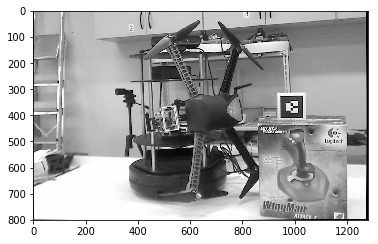

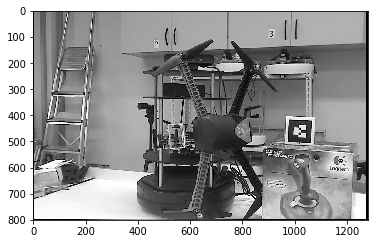

(1280, 1600)
(1280, 800)


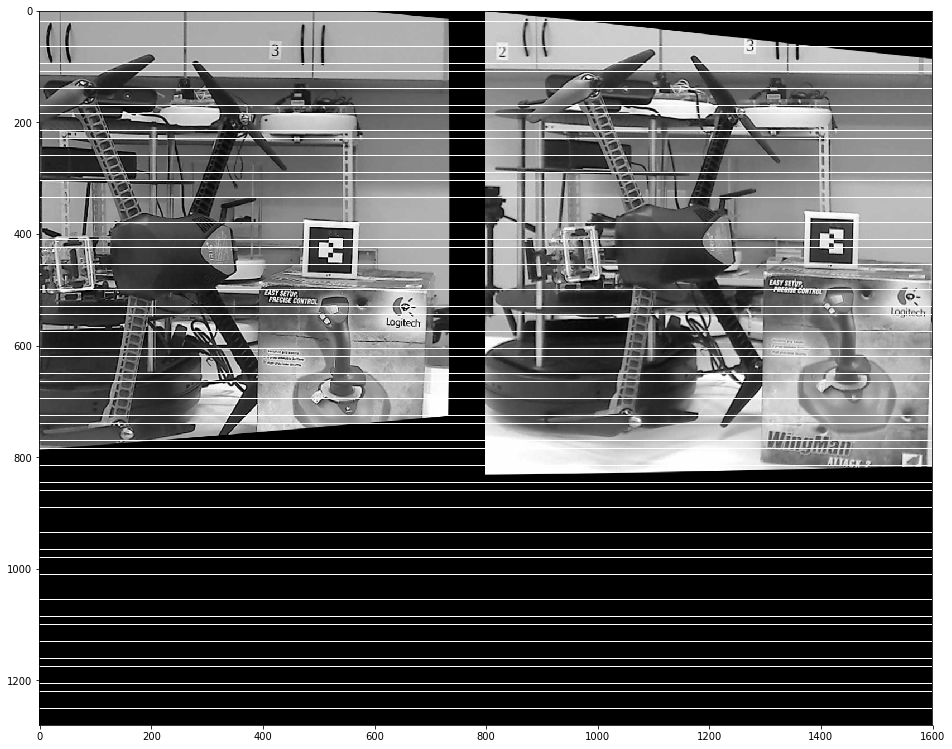

In [242]:
row,col = img1.shape
#print(row)
#print(col)
fx1 = 1536.2219
fy1 = 1575.0879
K1 = np.diag([fx1,fy1,1])
K1[0,2] = 480.3704
K1[1,2] = 420.4541
print ()
print ("matrix K for img1 is")
print(K1)
dd1 = np.array([0.0275, -0.0078, 0, 0, 0])


fx2 = 1538.2545
fy2 = 1575.0879
K2 = np.diag([fx2,fy2,1])
K2[0,2] = 480.3704
K2[1,2] = 420.4541
print ()
print ("matrix K for img2 is")
print(K2)
dd2 = np.array([0.0675, -0.1337, 0, 0, 0])    
   
E1 = K1.T.dot(F).dot(K1)
print ()
print ("The essential matrix E for img1 is")
print (E1)
print ()

E2 = K2.T.dot(F).dot(K2)
print ()
print ("The essential matrix E for img2 is")
print (E2)
print ()


#U,S,V = np.linalg.svd(F)
#e = V[-1]
#epipolo = e/e[2]
#print ()
#print ("The epipolo for img1 is")
#print(epipolo)

K_inv = np.linalg.inv(K1)

# find rotate and translation
U,S,Vt = np.linalg.svd(E1) 
if np.linalg.det(np.dot(U,Vt))<0:
    Vt = -Vt

E = np.dot(U,np.dot(np.diag([1.0,1.0,0.0]),Vt))

def in_front_of_both_cameras(first_points, second_points, rot, trans):
    # check if the point correspondences are in front of both images
    rot_inv = rot
    for first, second in zip(first_points, second_points):
        first_z = np.dot(rot[0, :] - second[0]*rot[2, :], trans) / np.dot(rot[0, :] - second[0]*rot[2, :], second)
        first_3d_point = np.array([first[0] * first_z, second[0] * first_z, first_z])
        second_3d_point = np.dot(rot.T, first_3d_point) - np.dot(rot.T, trans)

        if first_3d_point[2] < 0 or second_3d_point[2] < 0:
            return False

    return True

W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)

first_inliers = []
second_inliers = []
for i in range(len(pts1)):
    # normalize and homogenize the image coordinates
    first_inliers.append(K_inv.dot([pts1[i][0], pts1[i][1], 1.0]))
    second_inliers.append(K_inv.dot([pts2[i][0], pts2[i][1], 1.0]))

# Determine the correct choice of second camera matrix
# only in one of the four configurations will all the points be in front of both cameras
# First choice: R = U * Wt * Vt, T = +u_3 (See Hartley Zisserman 9.19)

R = U.dot(W).dot(Vt)
#R = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)
T = U[:, 2]
if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):

    # Second choice: R = U * W * Vt, T = -u_3
    T = - U[:, 2]
    if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):

        # Third choice: R = U * Wt * Vt, T = u_3
        R = U.dot(W.T).dot(Vt)
        T = U[:, 2]

        if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):

            # Fourth choice: R = U * Wt * Vt, T = -u_3
            T = - U[:, 2]

# Computing Euler angles

thetaX = np.arctan2(R[1][2], R[2][2])
c2 = np.sqrt((R[0][0]*R[0][0] + R[0][1]*R[0][1]))

thetaY = np.arctan2(-R[0][2], c2)

s1 = np.sin(thetaX)
c1 = np.cos(thetaX)

thetaZ = np.arctan2((s1*R[2][0] - c1*R[1][0]), (c1*R[1][1] - s1*R[2][1]))

print ()
print ("Pitch: %f, Yaw: %f, Roll: %f"%(thetaX*180/np.pi, thetaY*180/np.pi, thetaZ*180/np.pi))
print ()
print ("Rotation matrix:")
print (R)
print ()
print ("Translation vector:")
print (T)

match_inliers1 = first_inliers
match_inliers2 = second_inliers
Rt1 = np.hstack((np.eye(3), np.zeros((3, 1))))
Rt2 = np.hstack((R, T.reshape(3, 1)))

Rot = Rt2[:,:3]
Tras = Rt2[:, 3]
#print(Rot)
#print(Tras)


img1 = cv2.undistort(img1, K1, dd1)
img2 = cv2.undistort(img2, K2, dd2)
plt.imshow(img11,cmap = 'gray')
plt.show()
plt.imshow(img22,cmap = 'gray')
plt.show()

#perform the rectification
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(K1, dd1, K2, dd2, img1.shape[:2], Rot, Tras, alpha=1.0)

mapx1, mapy1 = cv2.initUndistortRectifyMap(K1, dd1, R1, K1, img1.shape[:2], cv2.CV_32F)

mapx2, mapy2 = cv2.initUndistortRectifyMap(K2, dd2, R2, K2, img2.shape[:2], cv2.CV_32F) 

img_rect1 = cv2.remap(img1, mapx1, mapy1, cv2.INTER_LINEAR)
img_rect2 = cv2.remap(img2, mapx2, mapy2, cv2.INTER_LINEAR)

# draw the images side by side
total_size = (max(img_rect1.shape[0], img_rect2.shape[0]), img_rect1.shape[1] + img_rect2.shape[1])
print(total_size)
print(img_rect1.shape)
img = np.zeros(total_size, np.uint8)
img[:img_rect1.shape[0], :img_rect1.shape[1]] = img_rect1
img[:img_rect2.shape[0], img_rect1.shape[1]:img_rect1.shape[1] + img_rect2.shape[1]] = img_rect2

# draw horizontal lines 
for i in range(20, img.shape[0], 15):
    cv2.line(img, (0, i), (img.shape[1], i), (255, 255, 0))


plt.figure(figsize=(16,16))
plt.imshow(img,cmap = 'gray')
plt.show()

Implementation of triangulation and Points cloud are shown below;

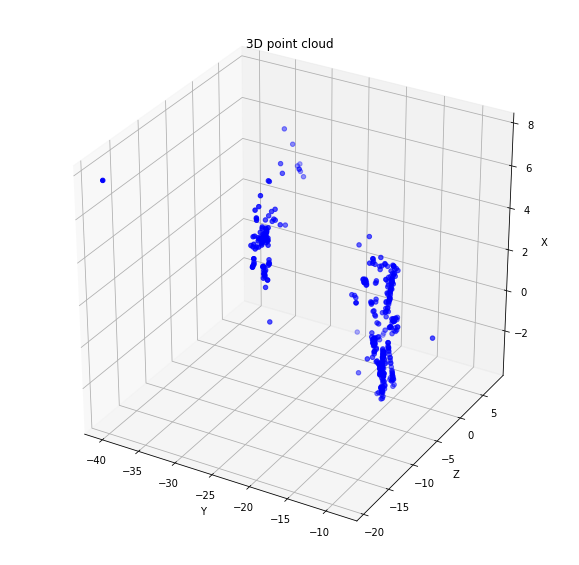

In [243]:

# triangulate points
first_inliers1 = np.array(match_inliers1).reshape(-1, 3)[:, :2]
second_inliers1 = np.array(match_inliers2).reshape(-1, 3)[:, :2]
pts4D = cv2.triangulatePoints(Rt1, Rt2, first_inliers1.T, second_inliers1.T).T

# convert from homogeneous coordinates to 3D
pts3D = pts4D[:, :3]/np.repeat(pts4D[:, 3], 3).reshape(-1, 3)

# plot points cloud
Ys = pts3D[:, 0]
Zs = pts3D[:, 1]
Xs = pts3D[:, 2]

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs, Ys, Zs, c='b', marker='o')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('X')
plt.title('3D point cloud')
plt.show()

the Disparity map in stereo images is shown below. we have two images of same scene, we can get depth information from that in an intuitive way.

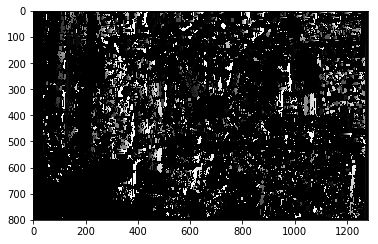

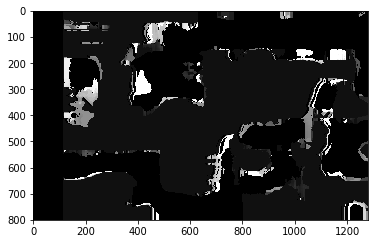

In [244]:
#img1 = cv2.imread('fotosparstereo/scene_cam02.jpg',0)  # left image
#img2 = cv2.imread('fotosparstereo/scene_cam01.jpg',0)  # right image
stereo1 = cv2.StereoBM_create(numDisparities=32, blockSize=13)
disparity1 = stereo1.compute(img1,img2)
plt.imshow(disparity1,'gray')
plt.show()


window_size = 200
num_disp = 16
stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        blockSize = 90,
        P1 = 8*3*window_size**2,
        P2 = 32*3*window_size**2,
        disp12MaxDiff = 1,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
                               
    )

# morphology settings
kernel = np.ones((12,12),np.uint8)
 
counter = 400
 
while counter < 650:  
    counter += 1  
    if counter % 3 != 0: continue
    filename = str(counter).zfill(4) 
    image_left = img1
    image_right = img2
    # compute disparity
    disparity = stereo.compute(image_left, image_right).astype(np.float32) 
    disparity = (disparity-min_disp)/num_disp
plt.imshow(disparity,'gray')
plt.show()